In [42]:
import umap
import numpy as np
import matplotlib.pyplot as plt

In [34]:
import os
cur_dir = os.getcwd()
print(cur_dir)

E:\python\2024.12.01\ContraVis_next


In [35]:
raw_data = np.load(r"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_none\features.npy")
labels = np.load(r"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_none\labels.npy")

In [41]:
pattern_type = "random"
intensity = 0.3
noisy_data = np.load(rf"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_{pattern_type}_{intensity}\features.npy")
# noisy_data = raw_data

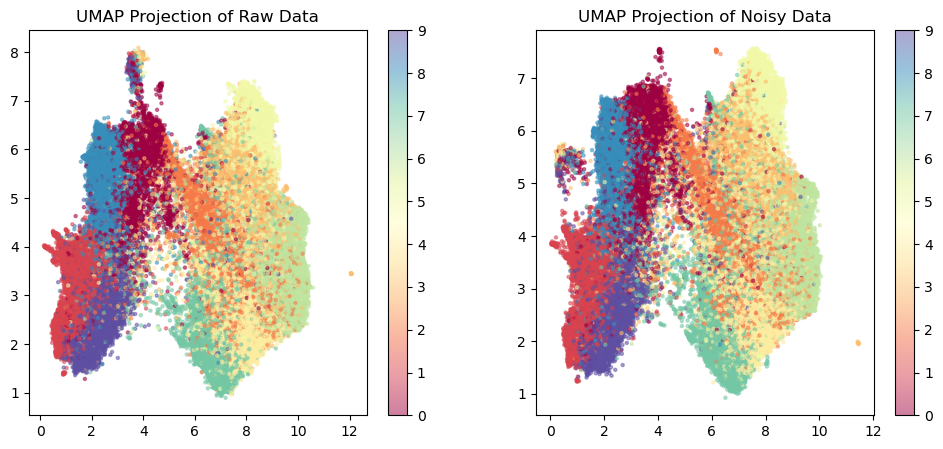

In [5]:
# 使用UMAP降维
umap_reducer = umap.UMAP(n_components=2, n_jobs=-1)

# 对原始数据和噪声数据进行降维
raw_embedded = umap_reducer.fit_transform(raw_data)
noisy_embedded = umap_reducer.fit_transform(noisy_data)

# 绘制UMAP结果
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(raw_embedded[:, 0], raw_embedded[:, 1], c=labels, cmap='Spectral', alpha=0.5, s=5)
axes[0].set_title("UMAP Projection of Raw Data")
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(noisy_embedded[:, 0], noisy_embedded[:, 1], c=labels, cmap='Spectral', alpha=0.5, s=5)
axes[1].set_title("UMAP Projection of Noisy Data")
plt.colorbar(scatter2, ax=axes[1])

plt.show()

In [43]:
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components

# 设定 KNN 近邻数
k = 10  

# 计算 KNN 图
knn_graph1 = kneighbors_graph(raw_data, n_neighbors=k, mode='connectivity', include_self=False)
n_components1, labels1 = connected_components(knn_graph1, directed=False)
print("G1-子图数量:", n_components1)
knn_graph2 = kneighbors_graph(noisy_data, n_neighbors=k, mode='connectivity', include_self=False)
n_components2, labels2 = connected_components(knn_graph2, directed=False)
print("G2-子图数量:", n_components2)

# 构造 NetworkX 图
G1 = nx.Graph(knn_graph1)
G2 = nx.Graph(knn_graph2)

G1-子图数量: 1
G2-子图数量: 1


In [44]:
import networkx as nx
import numpy as np
from grakel.kernels import WeisfeilerLehman
from grakel import Graph
from tqdm import tqdm  # 进度条显示

def convert_nx_to_grakel(G, node):
    """将 NetworkX 子图转换为 Grakel 格式，并添加显式节点标签"""
    if node not in G:
        return None

    neighbors = list(G.neighbors(node)) + [node]  # 取该点及其邻居
    subgraph = G.subgraph(neighbors)  # 提取子图

    # 添加显式的 labels
    node_labels = {n: str(n) for n in subgraph.nodes()}  # 确保节点有标签
    edges = list(subgraph.edges())

    return Graph(edges, node_labels=node_labels)

# 找出 G1 和 G2 的公共节点
common_nodes = set(G1.nodes()).intersection(set(G2.nodes()))

# 存储相似度
similarity_scores = {}

# 遍历所有公共节点，计算 WL 相似度
for node in tqdm(common_nodes, desc="计算 WL 核相似度"):
    grakel_graph1 = convert_nx_to_grakel(G1, node)
    grakel_graph2 = convert_nx_to_grakel(G2, node)

    # 确保转换成功
    if grakel_graph1 is None or grakel_graph2 is None:
        continue

    # 计算 Weisfeiler-Lehman Graph Kernel 近似 TED
    wl_kernel = WeisfeilerLehman(n_iter=3, normalize=True)
    wl_kernel.fit([grakel_graph1])  # 训练 G1 的子图
    ted_sim_score = wl_kernel.transform([grakel_graph2])[0][0]  # 计算 G2 子图的相似度

    # 存储结果
    similarity_scores[node] = ted_sim_score

# 转换为 NumPy 数组 (可选)
node_list = np.array(list(similarity_scores.keys()))
similarity_values = np.array(list(similarity_scores.values()))

# 输出部分结果
print(f"\n计算完成，共 {len(similarity_scores)} 个节点相似度被计算。")
for node, score in list(similarity_scores.items())[:10]:  # 仅显示前 10 个结果
    print(f"节点 {node} 的 TED 近似相似度: {score:.4f}")


计算 WL 核相似度: 100%|█████████████████████████████████████████████████████████| 50000/50000 [06:18<00:00, 132.19it/s]


计算完成，共 50000 个节点相似度被计算。
节点 0 的 TED 近似相似度: 0.0786
节点 1 的 TED 近似相似度: 0.0133
节点 2 的 TED 近似相似度: 0.0209
节点 3 的 TED 近似相似度: 0.0269
节点 4 的 TED 近似相似度: 0.0185
节点 5 的 TED 近似相似度: 0.0800
节点 6 的 TED 近似相似度: 0.0914
节点 7 的 TED 近似相似度: 0.0186
节点 8 的 TED 近似相似度: 0.0289
节点 9 的 TED 近似相似度: 0.0506


In [45]:
# 按相似度降序排序
sorted_scores = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

# 输出前 10 个相似度最高的节点
print("\n前 10 个相似度最高的节点及其 TED 近似相似度:")
for rank, (node, score) in enumerate(sorted_scores[:10], start=1):
    print(f"Rank {rank}: 节点 {node} 的 TED 近似相似度: {score:.4f}")



前 10 个相似度最高的节点及其 TED 近似相似度:
Rank 1: 节点 42646 的 TED 近似相似度: 0.4091
Rank 2: 节点 46743 的 TED 近似相似度: 0.3750
Rank 3: 节点 37488 的 TED 近似相似度: 0.3409
Rank 4: 节点 6464 的 TED 近似相似度: 0.3345
Rank 5: 节点 23245 的 TED 近似相似度: 0.3333
Rank 6: 节点 2181 的 TED 近似相似度: 0.3279
Rank 7: 节点 20210 的 TED 近似相似度: 0.3203
Rank 8: 节点 43414 的 TED 近似相似度: 0.3086
Rank 9: 节点 2397 的 TED 近似相似度: 0.3046
Rank 10: 节点 30591 的 TED 近似相似度: 0.3046


In [46]:
similarity_values = np.array(list(similarity_scores.values()))
np.save(rf"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_{pattern_type}_{intensity}\similarity.npy",similarity_values)
# 计算平均值和中位数
mean_similarity = np.mean(similarity_values)
median_similarity = np.median(similarity_values)
print(f"平均相似度: {mean_similarity:.4f}")
print(f"中位数相似度: {median_similarity:.4f}")

平均相似度: 0.0320
中位数相似度: 0.0218


ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of labels (10).

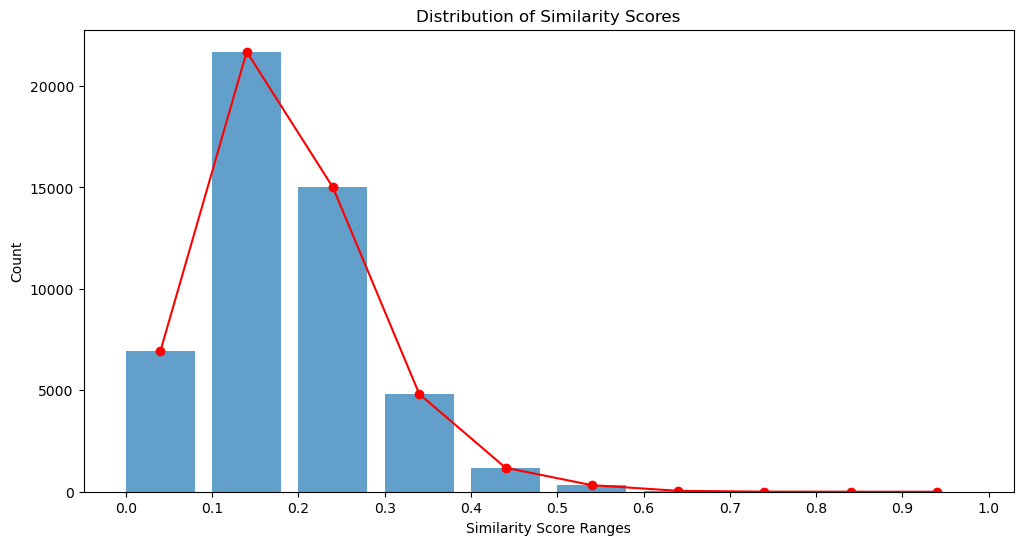

In [10]:
bins = np.arange(0, 1.1, 0.1)  # 从0到1，步长0.1
hist, bin_edges = np.histogram(list(similarity_scores.values()), bins=bins)

# 可视化
plt.figure(figsize=(12, 6))

# 柱状图
plt.bar(bin_edges[:-1], hist, width=0.08, alpha=0.7, label="Frequency", align="edge")

# 曲线图
plt.plot(bin_edges[:-1] + 0.04, hist, marker='o', linestyle='-', color='r', label="Trend")

# 细节调整
plt.xlabel("Similarity Score Ranges")
plt.ylabel("Count")
plt.title("Distribution of Similarity Scores")
plt.xticks(bin_edges, [f"{b:.1f}-{b+0.1:.1f}" for b in bin_edges[:-1]], rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 显示图表
plt.show()

(50000,)

In [11]:
import numpy as np
from collections import defaultdict

# 加载类别标签
labels = np.load(r"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_none\labels.npy")

# 确保 labels 的长度和 similarity_scores 的索引一致
if len(labels) < max(similarity_scores.keys()) + 1:
    raise ValueError("labels.npy 的长度与 similarity_scores 索引不匹配！")

# 计算每个类别的平均相似度
class_similarity = defaultdict(list)

for node, sim_score in similarity_scores.items():
    class_label = labels[node]  # 获取该节点对应的类别
    class_similarity[class_label].append(sim_score)

# 计算每个类别的平均相似度
class_avg_similarity = {cls: np.mean(scores) for cls, scores in class_similarity.items()}

# 输出结果
print("\n每个类别的平均相似度：")
for cls, avg_sim in sorted(class_avg_similarity.items()):
    print(f"类别 {cls}: 平均相似度 = {avg_sim:.4f}")



每个类别的平均相似度：
类别 0: 平均相似度 = 0.2116
类别 1: 平均相似度 = 0.1937
类别 2: 平均相似度 = 0.2060
类别 3: 平均相似度 = 0.1847
类别 4: 平均相似度 = 0.1847
类别 5: 平均相似度 = 0.2122
类别 6: 平均相似度 = 0.1864
类别 7: 平均相似度 = 0.2019
类别 8: 平均相似度 = 0.1781
类别 9: 平均相似度 = 0.1858


In [12]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import networkx as nx
import numpy as np

# 创建 Dash App
app = dash.Dash(__name__)

# Dash 布局
app.layout = html.Div([
    html.H1("UMAP & KNN 交互可视化"),

    # 用户输入索引
    html.Label("输入索引:"),
    dcc.Input(id="input-index", type="number", value=0, min=0, step=1, debounce=True),

    # UMAP 降维可视化
    html.Div([
        dcc.Graph(id="umap-raw"),
        dcc.Graph(id="umap-noisy")
    ], style={"display": "flex", "width": "100%"}),

    # 邻居索引及相似度
    html.H3("邻居索引及相似度:"),
    html.Div(id="neighbor-table")
])

# 更新 UMAP 散点图
@app.callback(
    [Output("umap-raw", "figure"),
     Output("umap-noisy", "figure")],
    [Input("input-index", "value")]
)
def update_umap_plot(index):
    # 确保 index 是整数
    if isinstance(index, np.ndarray):
        index = int(index[0])

    # 防止索引越界
    if index < 0 or index >= len(raw_embedded):
        return go.Figure(), go.Figure()

    # 获取 G1 的邻居
    neighbors1 = list(G1.neighbors(index)) if index in G1 else []

    # 获取 G2 的邻居
    neighbors2 = list(G2.neighbors(index)) if index in G2 else []

    # 只显示选中点 + 邻居
    filtered_indices1 = [index] + neighbors1
    filtered_indices2 = [index] + neighbors2

    def create_umap_figure(embedded_data, filtered_indices, title):
        fig = go.Figure()

        # 绘制邻居点
        fig.add_trace(go.Scatter(
            x=embedded_data[filtered_indices, 0], 
            y=embedded_data[filtered_indices, 1],
            mode="markers+text",
            marker=dict(size=8, color="blue"),
            text=[str(i) for i in filtered_indices],
            textposition="top center",
            name="邻居"
        ))

        # 高亮选中点
        fig.add_trace(go.Scatter(
            x=[embedded_data[index, 0]], y=[embedded_data[index, 1]],
            mode="markers+text",
            marker=dict(size=12, color="red", symbol="star"),
            text=[str(index)],
            textposition="top center",
            name="选中点"
        ))

        fig.update_layout(title=title, xaxis_title="UMAP X", yaxis_title="UMAP Y", showlegend=True)
        return fig

    return create_umap_figure(raw_embedded, filtered_indices1, "UMAP 降维 - 原始数据 (G1)"), \
           create_umap_figure(noisy_embedded, filtered_indices2, "UMAP 降维 - 扰动数据 (G2)")


# 显示邻居索引和相似度
@app.callback(
    Output("neighbor-table", "children"),  
    [Input("input-index", "value")]
)
def update_neighbor_info(index):
    # 确保 index 是整数
    if isinstance(index, np.ndarray):
        index = int(index[0])

    # 获取 G1 的邻居
    neighbors1 = set(G1.neighbors(index)) if index in G1 else set()

    # 获取 G2 的邻居
    neighbors2 = set(G2.neighbors(index)) if index in G2 else set()

    # 计算邻居交集
    common_neighbors = neighbors1.intersection(neighbors2)

    # 获取相似度（从 similarity_values 直接取 index）
    similarity_score = similarity_values[index] if index < len(similarity_values) else 0

    # 没有邻居时返回提示
    if not neighbors1 and not neighbors2:
        return html.Div(f"选中点: {index} | 相似度: {similarity_score:.4f} | 该点在两个 G 图中都没有邻居")

    # 分别创建邻居表
    table1 = html.Div([
        html.H4("G1 邻居"),
        html.Ul([html.Li(f"索引 {nbr}") for nbr in sorted(neighbors1)])
    ]) if neighbors1 else html.Div("G1 无邻居")

    table2 = html.Div([
        html.H4("G2 邻居"),
        html.Ul([html.Li(f"索引 {nbr}") for nbr in sorted(neighbors2)])
    ]) if neighbors2 else html.Div("G2 无邻居")

    table_common = html.Div([
        html.H4("G1 ∩ G2 交集邻居"),
        html.Ul([html.Li(f"索引 {nbr}") for nbr in sorted(common_neighbors)])
    ]) if common_neighbors else html.Div("G1 和 G2 没有共同邻居")

    return html.Div([
        html.H3(f"选中点: {index} | 相似度: {similarity_score:.4f}"),
        table1, html.Br(), table2, html.Br(), table_common
    ])


# 运行 Dash 应用
if __name__ == "__main__":
    app.run_server(debug=True)
